Ok so recap:
I've been up all night lol
I managed to get fresh data loaded
But something was happening with the preprocessor
Because my models were not making ANY sens.
It's also possible that my visualizing was off
But regardless, we had semi-working code before,
And we built some new models too
While I should have pivoted at least an hour ago (if not two) I'm not counting this as time wasted
(Unless I end up not finishing the project)

This notebook was written based on these resources:
https://www.kaggle.com/code/someadityamandal/bitcoin-time-series-forecasting/notebook
https://github.com/dataquestio/project-walkthroughs/tree/master/bitcoin_price
https://www.geeksforgeeks.org/time-series-forecasting-using-tensorflow/

Special thank you to David for, as always, having the best resources.

In [1]:
import numpy as np
import pandas as pd
import keras.layers as layers
import keras.models as models

import datetime, pytz
from sklearn.preprocessing import MinMaxScaler

import os
print(os.listdir('./data'))

2024-11-16 04:41:58.152559: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 04:41:58.182844: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 04:41:58.298972: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 04:41:58.435915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 04:41:58.543548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

['coinbaseUSD.csv', 'bitstampUSD.csv']


In [2]:
def dateparse(time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

data = pd.read_csv('./data/coinbaseUSD.csv', parse_dates=[0], date_parser=dateparse)

data.info()
print(data.head)

/tmp/ipykernel_307105/176637671.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('./data/coinbaseUSD.csv', parse_dates=[0], date_parser=dateparse)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099760 entries, 0 to 2099759
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   Timestamp          datetime64[ns, UTC]
 1   Open               float64            
 2   High               float64            
 3   Low                float64            
 4   Close              float64            
 5   Volume_(BTC)       float64            
 6   Volume_(Currency)  float64            
 7   Weighted_Price     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 128.2 MB
<bound method NDFrame.head of                         Timestamp     Open     High      Low    Close  \
0       2014-11-30 23:33:00+00:00   300.00   300.00   300.00   300.00   
1       2014-11-30 23:34:00+00:00      NaN      NaN      NaN      NaN   
2       2014-11-30 23:35:00+00:00      NaN      NaN      NaN      NaN   
3       2014-11-30 23:36:00+00:00      NaN      NaN      NaN

In [3]:
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)
data['Weighted_Price'].fillna(value=0, inplace=True)

data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

print(data.head())

                  Timestamp   Open   High    Low  Close  Volume_(BTC)  \
0 2014-11-30 23:33:00+00:00  300.0  300.0  300.0  300.0          0.01   
1 2014-11-30 23:34:00+00:00  300.0  300.0  300.0  300.0          0.00   
2 2014-11-30 23:35:00+00:00  300.0  300.0  300.0  300.0          0.00   
3 2014-11-30 23:36:00+00:00  300.0  300.0  300.0  300.0          0.00   
4 2014-11-30 23:37:00+00:00  300.0  300.0  300.0  300.0          0.00   

   Volume_(Currency)  Weighted_Price  
0                3.0           300.0  
1                0.0             0.0  
2                0.0             0.0  
3                0.0             0.0  
4                0.0             0.0  


/tmp/ipykernel_307105/537992000.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Volume_(BTC)'].fillna(value=0, inplace=True)
/tmp/ipykernel_307105/537992000.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [4]:
start = datetime.datetime(2015, 1, 1, 0,0,0,0, pytz.UTC)
end = datetime.datetime(2018, 11,11,0,0,0,0, pytz.UTC)

weekly_rows = data[(data['Timestamp'] >= start) & (
    data['Timestamp'] <= end)].groupby(
        [pd.Grouper(key='Timestamp', freq='W-MON')]
    ).first().reset_index()

print(weekly_rows.head())

                  Timestamp    Open    High     Low   Close  Volume_(BTC)  \
0 2015-01-12 00:00:00+00:00  360.00  360.00  360.00  360.00         0.010   
1 2015-01-19 00:00:00+00:00  260.00  260.00  260.00  260.00         0.000   
2 2015-01-26 00:00:00+00:00  225.51  225.51  225.51  225.51         0.000   
3 2015-02-02 00:00:00+00:00  259.99  259.99  259.99  259.99         0.300   
4 2015-02-09 00:00:00+00:00  239.28  239.50  239.28  239.50        20.675   

   Volume_(Currency)  Weighted_Price  
0           3.600000      360.000000  
1           0.000000        0.000000  
2           0.000000        0.000000  
3          77.997000      259.990000  
4        4951.178693      239.476599  


In [5]:
data = pd.read_csv('./data/coinbaseUSD.csv', parse_dates=[0], date_parser=dateparse)
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)

data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()

data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_307105/105282266.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('./data/coinbaseUSD.csv', parse_dates=[0], date_parser=dateparse)
/tmp/ipykernel_307105/105282266.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
/tmp/ipykernel_307105/105282266.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[co

In [6]:
split_date = '25-Jun-2018'

data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [7]:
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [8]:
model1 = models.Sequential()

model1.add(layers.LSTM(128, activation='relu', input_shape=(1, 1)))
model1.add(layers.Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

model2 = models.Sequential()

# This one's more promising than the other's I've seen
model2.add(layers.LSTM(100, return_sequences=True))
model2.add(layers.LSTM(100, return_sequences=True))
model2.add(layers.LSTM(50))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1, activation= 'linear'))
# Interesting that this one does two different activation functions
# Suppose that makes sense though

# Ok last one is that weird amalgamation I did last time.
# Copy and pasting isn't cheating when it's your own code
model3 = models.Sequential()

model3.add(layers.LSTM(128, activation='relu', input_shape=(1, 1)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
625/625 - 4s - 6ms/step - loss: 0.0066
Epoch 2/100
625/625 - 2s - 3ms/step - loss: 5.3629e-05
Epoch 3/100
625/625 - 2s - 3ms/step - loss: 2.5424e-05
Epoch 4/100
625/625 - 2s - 3ms/step - loss: 1.2777e-05
Epoch 5/100
625/625 - 2s - 3ms/step - loss: 1.1872e-05
Epoch 6/100
625/625 - 2s - 3ms/step - loss: 1.1653e-05
Epoch 7/100
625/625 - 2s - 2ms/step - loss: 1.1937e-05
Epoch 8/100
625/625 - 2s - 3ms/step - loss: 1.1909e-05
Epoch 9/100
625/625 - 2s - 3ms/step - loss: 1.2316e-05
Epoch 10/100
625/625 - 2s - 3ms/step - loss: 1.2278e-05
Epoch 11/100
625/625 - 3s - 4ms/step - loss: 1.2609e-05
Epoch 12/100
625/625 - 2s - 4ms/step - loss: 1.1947e-05
Epoch 13/100
625/625 - 2s - 3ms/step - loss: 1.2351e-05
Epoch 14/100
625/625 - 2s - 3ms/step - loss: 1.2871e-05
Epoch 15/100
625/625 - 2s - 3ms/step - loss: 1.2373e-05
Epoch 16/100
625/625 - 3s - 5ms/step - loss: 1.2289e-05
Epoch 17/100
625/625 - 2s - 3ms/step - loss: 1.2532e-05
Epoch 18/100
625/625 - 2s - 3ms/step - loss: 1.2421e-05
Epoch

In [10]:
model1.summary()
model2.summary()
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,069 (781.52 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,380 (521.02 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,075 (781.55 KB)

 Trainable params: 66,691 (260.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,384 (521.04 KB)

You know what? The visualization has been the second hardest thing yet
Doing it for 3 different models is WAY too much of a task
So we're going to go ahead and make a different kernel for each model
And then it can be a choose-your-own adventure.

Ok cool. I can't even get predictions to run

In [22]:
test_set = data_test.values
if len(test_set.shape) == 1:
    test_set = np.reshape(test_set, (len(test_set), 1))
else:
    test_set = test_set.reshape(-1, 1)

test_set = sc.transform(test_set)

X_test = test_set[0:len(test_set)-1]
X_test = np.reshape(X_test, (len(X_test), 1, 1))

Ok finally
I actually cried

In [25]:
predictions_model1 = model1.predict(X_test)
predictions_model1 = sc.inverse_transform(predictions_model1)

predictions_model2 = model2.predict(X_test)
predictions_model2 = sc.inverse_transform(predictions_model2)

predictions_model3 = model3.predict(X_test)
predictions_model3 = sc.inverse_transform(predictions_model3)

738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


ValueError: x and y must have same first dimension, but have shapes (4719,) and (23599,)

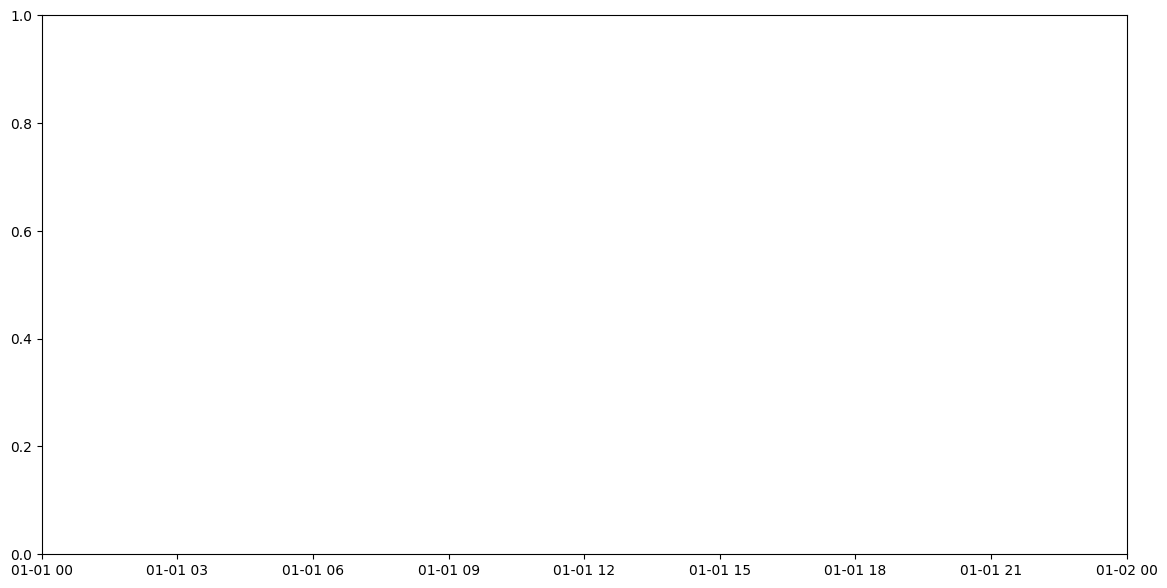

In [28]:
import matplotlib.pyplot as plt

predictions_model1_flat = predictions_model1.flatten()
predictions_model2_flat = predictions_model2.flatten()
predictions_model3_flat = predictions_model3.flatten()

plt.figure(figsize=(14, 7))
plt.plot(data_test.index[1:], predictions_model1_flat, color='red', label='Model 1 Predictions')
plt.plot(data_test.index[1:], predictions_model2_flat, color='blue', label='Model 2 Predictions')
plt.plot(data_test.index[1:], predictions_model3_flat, color='green', label='Model 3 Predictions')
plt.plot(data_test.index[1:], data_test['Weighted_Price'].values[1:], color='black', label='Actual Price')

plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()